## Credit Card fraud detection project


##### 1. importing important library :

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score , roc_curve,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import joblib





##### 2. loading the dataset :

In [3]:


df = pd.read_csv("creditcard.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

##### 3. Data Preprocessing


Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


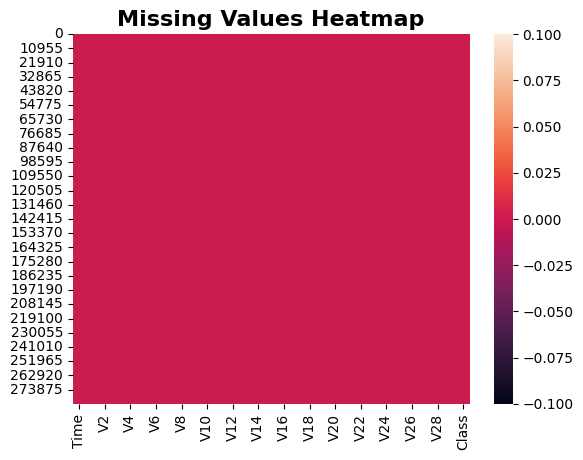

In [4]:


print("\nMissing values:\n", df.isnull().sum())
sns.heatmap(df.isnull())
plt.title("Missing Values Heatmap" ,fontsize=16 , fontweight='bold' )
plt.show()




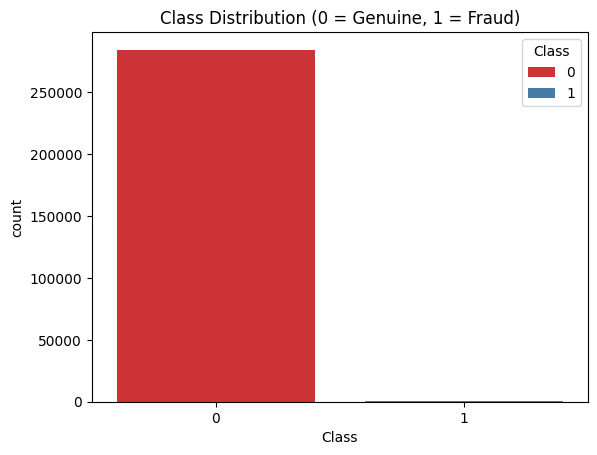


Fraud Cases: 492
Genuine Cases: 284315


In [5]:

# Step 4: Class Distribution

sns.countplot(data=df, x='Class' , palette='Set1' , hue='Class', order=df['Class'].value_counts().index)
plt.title("Class Distribution (0 = Genuine, 1 = Fraud)")
plt.show()

print("\nFraud Cases:", df['Class'].value_counts()[1])
print("Genuine Cases:", df['Class'].value_counts()[0])



In [6]:
# Drop 'Time' and scale 'Amount'

df = df.drop(['Time'], axis=1)

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Split into features and target
X = df.drop('Class', axis=1)
y = df['Class']

##### 4. Split the dataset

In [7]:

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


##### 5. Handle Class Imbalance using SMOTE

In [8]:

# Step 6: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



print("\nAfter SMOTE, Class Distribution:")
print(pd.Series(y_resampled).value_counts())


After SMOTE, Class Distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


##### 6. Build Models

In [9]:
#  Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)
lr_probs = lr.predict_proba(X_test)[:,1]
lr_preds = lr.predict(X_test)

## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)
rf_probs = rf.predict_proba(X_test)[:,1]
rf_preds = rf.predict(X_test)


##### 7. Evaluation Function with visuals

In [18]:


def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Model Evaluation")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d',cbar='blues' , xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_probs))

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_true, y_probs):.4f})')
    plt.plot([0,1], [0,1], linestyle='--', color='grey', label='Random Guessing' )
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

 


##### 8. Evaluate Both Models


Logistic Regression Model Evaluation
Confusion Matrix:
[[55355  1509]
 [    8    90]]


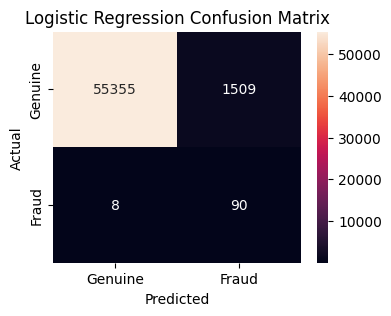


Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9735    0.9865     56864
           1     0.0563    0.9184    0.1061        98

    accuracy                         0.9734     56962
   macro avg     0.5281    0.9459    0.5463     56962
weighted avg     0.9982    0.9734    0.9850     56962

F1 Score: 0.1060695344725987
ROC-AUC Score: 0.970028112187475


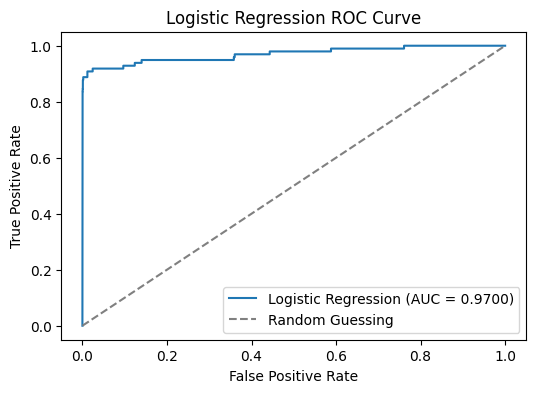


Random Forest Model Evaluation
Confusion Matrix:
[[56852    12]
 [   17    81]]


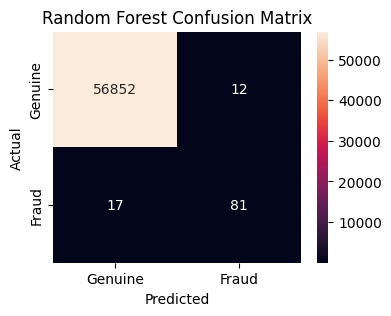


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962

F1 Score: 0.8481675392670157
ROC-AUC Score: 0.9736690944667118


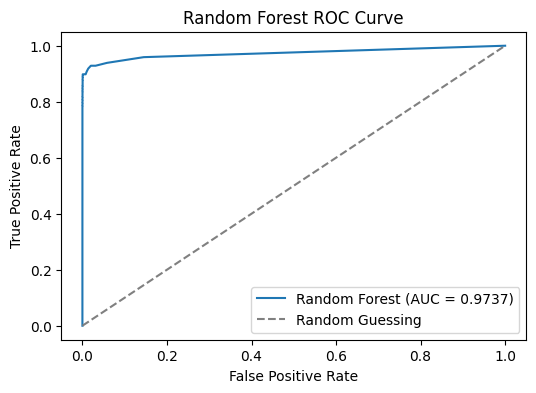

In [19]:
evaluate_model("Logistic Regression", y_test, lr_preds ,lr_probs)
evaluate_model("Random Forest", y_test, rf_preds , rf_probs)

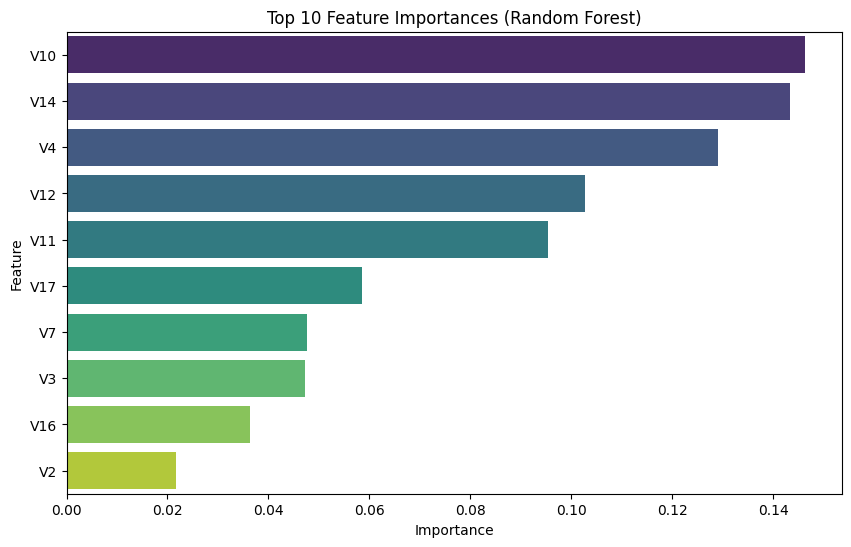

In [20]:

# Step 12: Feature Importance (Random Forest)
plt.figure(figsize=(10,6))
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10] , palette='viridis' ,hue=feat_imp.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### save the model

In [21]:
joblib.dump(rf, 'creditcard_fraud_rf_model.pkl')
print("Model saved as 'creditcard_fraud_rf_model.pkl'")

Model saved as 'creditcard_fraud_rf_model.pkl'
